# Time dependent D3D simulation

In [3]:
using Plots;
using FUSE
FUSE.ProgressMeter.ijulia_behavior(:clear);

In [16]:
@time begin
#shot = 133221; ini, act = FUSE.case_parameters(:D3D, shot; use_local_cache=true); # ECH
#ini, act = FUSE.case_parameters(:D3D, 200000); # ECH
#ini, act = FUSE.case_parameters(:D3D, 170325); # ECH 1.67924
shot = 168830; ini, act = FUSE.case_parameters(:D3D, shot; use_local_cache=true); #NBI with balanced torque
#shot = 194306; ini, act = FUSE.case_parameters(:D3D, shot; use_local_cache=true, new_impurity_match_power_rad=:Kr); # negT
#ini, act = FUSE.case_parameters(:D3D, 177476; use_local_cache=true, PROFILES_tree="ZIPFIT02"); # Cihan's
#@time ini, act = FUSE.case_parameters(:D3D, 168830);
#ini, act = FUSE.case_parameters(:D3D, 200204); # beam power scan, rotation, lower_to_upper null
#ini, act = FUSE.case_parameters(:D3D, 200021; EFIT_tree="EFIT01"); # negative B
#ini, act = FUSE.case_parameters(:D3D, 173389);
end
@checkin :fetch ini act

[ Info: Remote D3D data fetching for shot 194306
[ Info: Path on OMEGA: /cscratch/meneghini/d3d_data/194306
[ Info: Path on Localhost: /var/folders/m5/nn3rzlz151xds7zqy1dm94h00000gr/T/meneghini_D3D_194306
[ Info: Loading files: D3D_machine.json ; D3D_194306.h5 ; nbi_ods_194306.h5


  4.725417 seconds (40.17 M allocations: 4.950 GiB, 20.84% gc time, 4 lock conflicts)


┌ Warning: IMASdd.IMASbadExpression: Could not set new_impurity_radiation!(dd, Kr, -144085.9006506672) at time 0.30000001192092896
└ @ IMAS ~/.julia/dev/IMAS/src/physics/profiles.jl:1221


In [17]:
@checkout :fetch ini act;
ini.time.simulation_start = ini.general.dd.equilibrium.time_slice[2].time
dd = IMAS.dd()
@time FUSE.init!(dd, ini, act);
@checkin :init dd act;

actors: CXbuild
actors: HCD
actors:  SimpleEC
actors:  SimpleNB
actors:  NeutralFueling


 19.625144 seconds (6.40 M allocations: 9.465 GiB, 5.20% gc time)


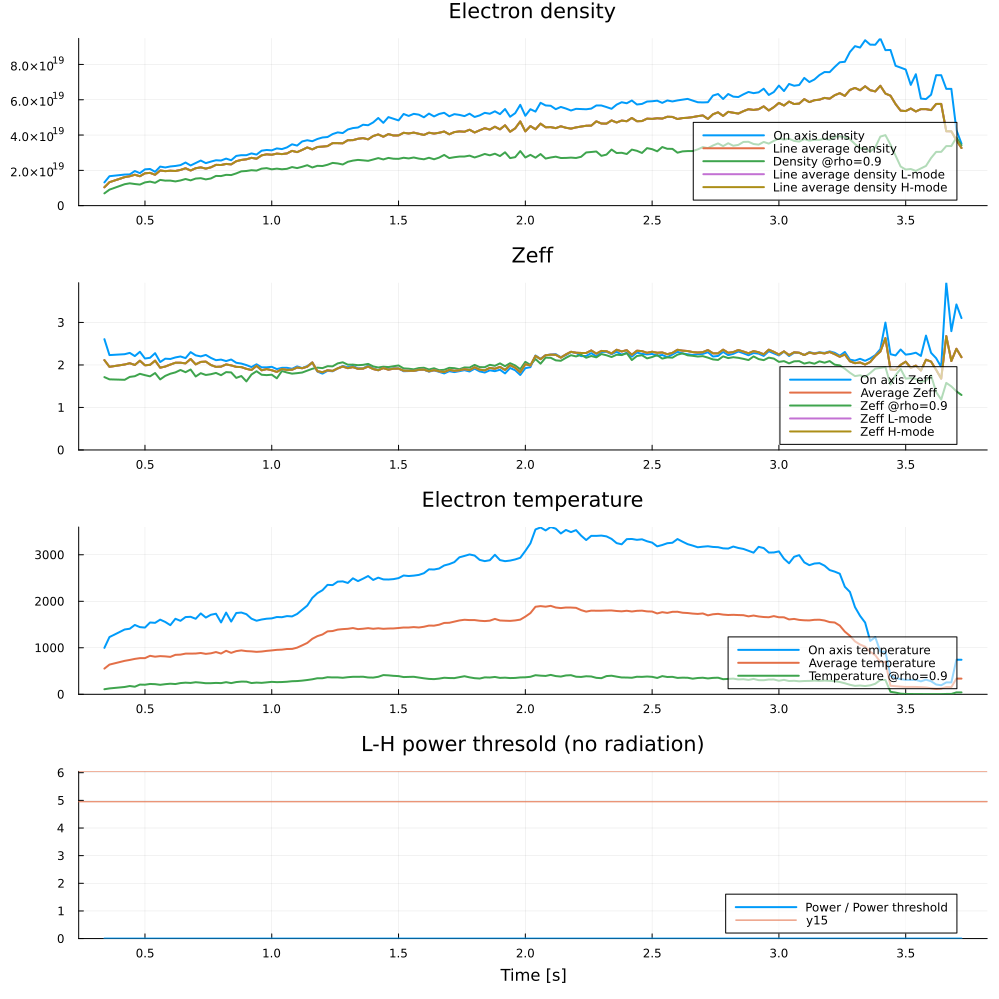

In [18]:
@checkout :init dd act;
experiment_LH = FUSE.LH_analysis(dd; scale_LH=5.5);

In [ ]:
@checkout :init dd act;
act.ActorPedestal.model = :dynamic
act.ActorPedestal.tau_n = experiment_LH.tau_n
act.ActorPedestal.tau_t = experiment_LH.tau_t
act.ActorWPED.ped_to_core_fraction = experiment_LH.W_ped_to_core_fraction
act.ActorEPED.ped_factor = 0.7
act.ActorPedestal.T_ratio_pedestal = 1.0 # Ti/Te in the pedestal
if true
    # density and Zeff from experiment
    act.ActorPedestal.density_ratio_L_over_H = 1.0
    act.ActorPedestal.zeff_ratio_L_over_H = 1.0
else
    # density can go from L to H mode at a different time
    act.ActorPedestal.density_ratio_L_over_H = experiment_LH.ne_L_over_H
    act.ActorPedestal.zeff_ratio_L_over_H = experiment_LH.zeff_L_over_H
    dd.pulse_schedule.density_control.n_e_line.reference = experiment_LH.ne_H
    dd.pulse_schedule.density_control.zeff_pedestal.reference = experiment_LH.zeff_H
end

if false
    # LH-transition from LH scaling law
    act.ActorPedestal.mode_transitions = missing
else
    # LH-transition at user-defined times
    act.ActorPedestal.mode_transitions = experiment_LH.mode_transitions
    act.ActorPedestal.mode_transitions[5.2] = :L_mode
    @show act.ActorPedestal.mode_transitions
end

act.ActorEquilibrium.model = :FRESCO # EGGO

act.ActorFRESCO.nR = 65
act.ActorFRESCO.nZ = 65

act.ActorNeutralFueling.τp_over_τe = 0.5

act.ActorFluxMatcher.evolve_plasma_sources = false
act.ActorFluxMatcher.algorithm = :simple
act.ActorFluxMatcher.max_iterations = -10
act.ActorFluxMatcher.verbose = false
act.ActorFluxMatcher.evolve_pedestal = false

act.ActorTGLF.tglfnn_model = "sat1_em_d3d"
# act.ActorTGLF.model = :GKNN
# act.ActorTGLF.tglfnn_model = "sat3_em_d3d_azf-1"

dd.global_time = ini.general.dd.equilibrium.time_slice[2].time # start_time
δt = 0.025
final_time = ini.general.dd.equilibrium.time[end]
#final_time = 0.5
act.ActorDynamicPlasma.Nt = Int(ceil((final_time - dd.global_time) / δt))
act.ActorDynamicPlasma.Δt = final_time - dd.global_time

act.ActorDynamicPlasma.evolve_current = true
act.ActorDynamicPlasma.evolve_equilibrium = true
act.ActorDynamicPlasma.evolve_transport = true
act.ActorDynamicPlasma.evolve_hcd = true
act.ActorDynamicPlasma.evolve_pf_active = false
act.ActorDynamicPlasma.evolve_pedestal = true

act.ActorDynamicPlasma.ip_controller = false
act.ActorDynamicPlasma.time_derivatives_sources = true

# act.ActorCurrent.model = :replay
# act.ActorEquilibrium.model = :replay
# act.ActorCoreTransport.model = :replay
# act.ActorPedestal.model = :replay
# act.ActorHCD.ec_model = :replay
# act.ActorHCD.ic_model = :replay
# act.ActorHCD.lh_model = :replay
# act.ActorHCD.nb_model = :replay
# act.ActorHCD.pellet_model = :replay
# act.ActorHCD.neutral_model = :none

@time actor = FUSE.ActorDynamicPlasma(dd, act; verbose=true);
@checkin :time_dep dd ini act actor;

In [24]:
using Interact
dd1 = FUSE.checkpoint[:init].dd
IMAS.trim_time!(dd, (-Inf, dd.global_time-1E-6)); # shaves off the last time slice, useful when simulation crashes and leaves last time-slice in a bad state

In [22]:
@manipulate for time0 in slider(dd.equilibrium.time, value=dd.global_time/2.0, label="time")
    try
        FUSE.plot_plasma_overview(dd, Float64(time0); dd1, aggregate_hcd=true, size=(1300,1000))#, min_power=1E4)
    catch
        plot!()
    end

    # p=plot(dd1.equilibrium; time0, color=:black)
    # plot!(dd.equilibrium; time0)
    # plot!(p[1], dd.wall)

    
    # plot(dd.core_transport; time0)

    # plot(dd.core_sources; time0, aggregate_radiation=true, aggregate_hcd=true)
    
    IMAS.ylim(Dict{Int,Float64}(
        -2 => 0.0, 
        -3 => 0.0, 3 => 1000.0,
        4 => 4.0,
        5 => 4.0,
        6 => 1E20,

        -8 => -0.2, 8 => 2.0,
        -9 => -0.25, 9 => .5,
        -10 => -0.25, 10 => .5,
        -11 => -1E20, 11 => 1.E20,
        
        -14 => 0.0, 14 => 0.101,
        -15 => 0.0, 15 => 0.101,
        -16 => -2.0E19, 16 => 2.0E19))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 429, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(202), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/meneghini/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/meneghini/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/meneghini/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), Asset("css", nothing, "/Users/meneghini/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), Asset("css", nothing, "/Users/meneghini/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable, started) @0x000000035d45c970, Task (runnable, started) @0x000000035d45c970), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 0)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.34\",\"0.36\",\"0.372477\",\"0.384953\",\"0.39743\",\"0.409907\",\"0.422383\",\"0.43486\",\"0.447336\",\"0.459813\",\"

In [ ]:
using Interact
using Printf

a = @animate for (k, time0) in enumerate(dd.equilibrium.time[2:end])
    println(k)
    try
        FUSE.plot_plasma_overview(dd, time0; dd1=dd1, aggregate_hcd=true)
    catch
        continue
    end
    
    IMAS.ylim(Dict{Int,Float64}(
        -2 => 0.0, 
        -3 => 0.0, 3 => 1000.0,
        4 => 4.0,
        5 => 4.0,
        6 => 1E20,

        -8 => -0.2, 8 => 2.0,
        -9 => -0.25, 9 => .5,
        -10 => -0.25, 10 => .5,
        -11 => -1E20, 11 => 1.E20,
        
        -14 => 0.0, 14 => 0.101,
        -15 => 0.0, 15 => 0.101,
        -16 => -2.0E19, 16 => 2.0E19))

    savefig("D3D_$(shot)/D3D_$(shot)___$(@sprintf("%04d", k)).png") # magick -delay 2 -loop 0 D3D_168830___*.png -layers Optimize D3D_194306.gif
end
gif(a, "D3D_$(shot)/D3D_$(shot).gif", fps=12)